# Community detection of HSE faculties via Network Analysis

## Note:

It was originally a university project. It was provided in docx format, and the main stages of analysis (building a graph, calculating metrics, identifying communities, making network visually better by applying Yifan Hu algorithm) were done in a specialized Gephi program. In order to be able to get acquainted with the main methods and results, it was decided to post a concise implementation of the study, adapted for the Python language, on GitHub.

I also want to draw attention to the fact that this project is not a solution to the problem and does not provide a ready-made final algorithm. The purpose is to substantiate the expediency of the chosen approach to solving problems of this type and to provide the initial version of the algorithm.

# 1 Introduction

### 1.1 Problem statement

Depending on the profile of the company, different employers want to see different employees in their team. For example, the IT sphere is interested in programmers, Audit – in economists, and so on. However, let's assume that we represent an IT company and are looking for a programmer. Is it fair to say that only graduates of the Faculty of Computer Science (FCS) will suit us? After all, it is possible that many faculties have similar training programs. For example, the program of the Faculty of Economic Sciences (FES)is inferior to the FCS in terms of studying mathematical disciplines. However, due to the tight connection of economics with mathematics, it provides a good mathematical base, as well as in-depth knowledge in many specialized areas. Based on this, it is logical to ask questions, students / graduates of which specialties will suit certain employers (for example, does it make sense to hire a graduate of FES for the position of manager, or it is necessary to look only at graduates of Management, and can a student of FCS work in a bank?).

Thus, the task is to learn to recognize, graduates of which educational programmes and universities will be suitable for certain employers for certain positions? This solves the problem of saving time, as well as subjectivity when hiring.




### 1.2 Implementation plan

We will conduct this research within the HSE faculties based on the courses taught using network analysis. Subsequently, it is possible to refine the algorithm and train the model based on a large amount of data, but at the same time it will take a lot of time and require a lot of experiments related to a particular area.

### 1.3 Data and their sources

The HSE website provides open access to academic disciplines that students study in various years of being at university. This was the source of the data. As part of the research, I took first-year subjects from 11 educational programs from different HSE faculties. The data is presented in the form of {Faculty (Program)}. It is worth clarifying that all faculties have Safe Living Basics (I decided not to take this subject into account), as well as English and an Independent Assessment of Digital Literacy (taken into account everywhere). 

A table consisting of two columns (Source, Target) was constructed, where source is the faculty, target is the course being studied. Thus, the number of sources is the number of faculties under consideration, the number of targets is the total number of subjects studied at all these faculties in the 1st year. 

Subsequently, the original form of the table was modified for more efficient operation of the model. Let's list the stages of data processing (it should be clarified that these changes are subjective):

1) Some faculties study very similar disciplines, but they have different names (for example, "Calculus-1" and "Calculus"). At the same time, they are recognized by the system as completely different disciplines, so we rename them in such a way that their name is identical 

2) To one degree or another, we take into account that for some programs a certain subject is specialized, and for some it is basic. For example, where the economy is specialized, there is a division into Microeconomics and Macroeconomics, and where it is basic – there is one subject named Economics. Thus, it turns out to differentiate the faculties from each other

3) Despite the different names of some subjects, their names were renamed identical in case of similarity of the concept (for example, research seminars and project seminars, foreign languages other than English, like Spanish or Italian)

# 2 Data analysis \& construction of first network

### 2.1 Representation of data 

We will start by showing the table representation of data we are dealing with (remember that initially this was a university project, hence, the data is in Russian)

In [61]:
import pandas as pd
import numpy as np
import networkx as nx
import networkx.algorithms.community as nxcom
from matplotlib import pyplot as plt
import community as community_louvain
import matplotlib.cm as cm

In [62]:
df = pd.read_excel('file.xlsx')
df

,source,target
0,МИЭМ (ИВТ),нез оценка по цифр грамотности
1,МИЭМ (ИВТ),история
2,МИЭМ (ИВТ),физика
3,МИЭМ (ИВТ),матан
4,МИЭМ (ИВТ),алгебра
...,...,...
120,ШИЯ,второй язык
121,ШИЯ,языкознание
122,ШИЯ,литература США
123,ШИЯ,культура работы с данными


### 2.2 Useful information before we move to the construction of the network

Our nodes are both source and target variables (we have 11 unique source values and 57 unique target values, that is, a total of 68 nodes). Our graph is not oriented, since the direction of the arrows and connections does not matter, and we do not assign it (the fact that the subject is studied at the faculty automatically implies the fact that the faculty teaches this subject. The graph is not weighted (in order to simplify the model, however, adding weights is a good way to indicate, whether the subject is advanced or basic)



### 2.3 Constuction of the network

We will use the degree of nodes to make the size of an element dependent on its importance

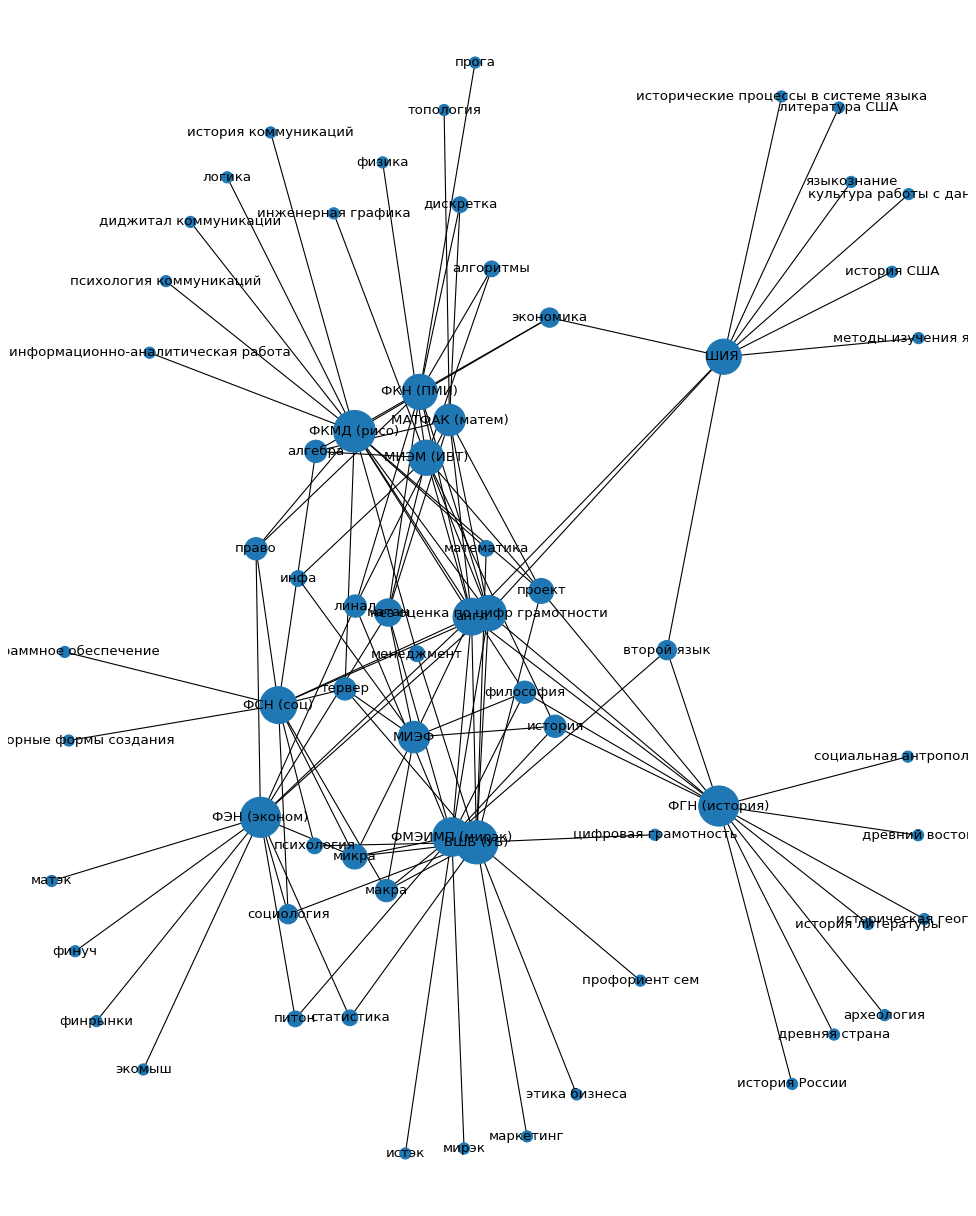

In [63]:
from matplotlib.pyplot import figure
figure(figsize=(12, 15), dpi=80)
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(df, create_using=Graphtype)
d = dict(G.degree)
nx.draw(G, nodelist=d.keys(), node_size=[v * 100 for v in d.values()], with_labels=True)
plt.show()

### 2.4 Now, using centrality, let's indicate the most important parameters

In [64]:
eigenvector_dict = nx.eigenvector_centrality(G)

In [65]:
for element in sorted(eigenvector_dict)[:20]:
    print(element)

ВШБ (УБ)
МАТФАК (матем)
МИЭМ (ИВТ)
МИЭФ
ФГН (история)
ФКМД (рисо)
ФКН (ПМИ)
ФМЭИМП (мирэк)
ФСН (соц)
ФЭН (эконом)
ШИЯ 
алгебра
алгоритмы
англ
археология
второй язык
диджитал коммуникации
дискретка
древний восток
древняя страна


Well, most important elements are the faculties, despite there are subjects that are taught everywhere. The important fact is that the importance of subjects is weakly correlated with its freedom (there is still a correlation since English and Digital Literacy are in top-6 and all top-3 are non-unique; on the other hand, there are many unique or almost unique subjects that are in top). Nevertheless, this part of analysis does not give meaningful interpretation of what is going on, therefore, let's move to the community detection part

### 2.5 Community detection (Louvain algorithm)

Here we will use Louvain algorithm at first, despite the dact that in the initial work I used Gephi built-in algorithm (it is based on modularity) algorithm

In the cell below we see the array representation of the situation if we apply the standard Python method

In [66]:
partition = community_louvain.best_partition(G)
a = {k: v for k, v in sorted(partition.items(), key=lambda item: item[1])}
print(a)

{'МИЭМ (ИВТ)': 0, 'физика': 0, 'алгебра': 0, 'инфа': 0, 'инженерная графика': 0, 'проект': 0, 'англ': 0, 'алгоритмы': 0, 'ФКН (ПМИ)': 0, 'дискретка': 0, 'линал': 0, 'прога': 0, 'МАТФАК (матем)': 0, 'топология': 0, 'нез оценка по цифр грамотности': 1, 'ШИЯ\xa0': 1, 'история США': 1, 'исторические процессы в системе языка': 1, 'языкознание': 1, 'литература США': 1, 'культура работы с данными': 1, 'методы изучения языка': 1, 'история': 2, 'матан': 2, 'питон': 2, 'ФМЭИМП (мирэк)': 2, 'истэк': 2, 'мирэк': 2, 'макра': 2, 'философия': 2, 'МИЭФ': 2, 'второй язык': 3, 'ФГН (история)': 3, 'история России': 3, 'историческая география': 3, 'археология': 3, 'древний восток': 3, 'социальная антропология': 3, 'история литературы': 3, 'древняя страна': 3, 'социология': 4, 'микра': 4, 'тервер': 4, 'ВШБ (УБ)': 4, 'маркетинг': 4, 'математика': 4, 'профориент сем': 4, 'психология': 4, 'цифровая грамотность': 4, 'этика бизнеса': 4, 'ФСН (соц)': 4, 'иллюзорные формы создания': 4, 'программное обеспечение': 

### 2.6 Unlabeled graphical representation of the modified network
Let's color our vertices based on their belonging to a particular community

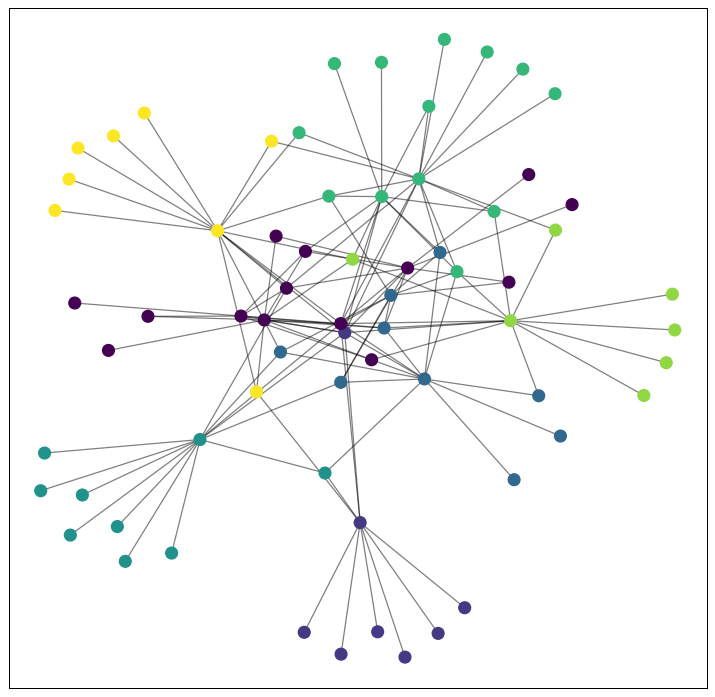

In [67]:
figure(figsize=(10, 10), dpi=90)
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=90,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

###### However, this is not what we usually want to see when doing network analysis. The point is to see visually, what is going on. That is why we need to move to the advanced methods that will show what is happening

# 3 Applying more advanced tools

### 3.1 Different approach

It will allow us to graphically interpret the results. However, before we construct a network, we need to define several functions that will help us in the future

In [68]:
G1 = G

In [69]:
def nodes(G1, communities):
        #Add community to node attributes
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G1.nodes[v]['community'] = c + 1
def edges(G1):
    #Find internal edges and add their community to their attributes
    for v, w, in G1.edges:
        if G1.nodes[v]['community'] == G1.nodes[w]['community']:
            # Internal edge, mark with community
            G1.edges[v, w]['community'] = G1.nodes[v]['community']
        else:
            # External edge, mark as 0
            G1.edges[v, w]['community'] = 0
def colors(i, r_off=1, g_off=1, b_off=1):
    #Assign a color to a vertex
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

### 3.2 New network (now community detection will be based on Modularity)

Your dataset has 6 communities.


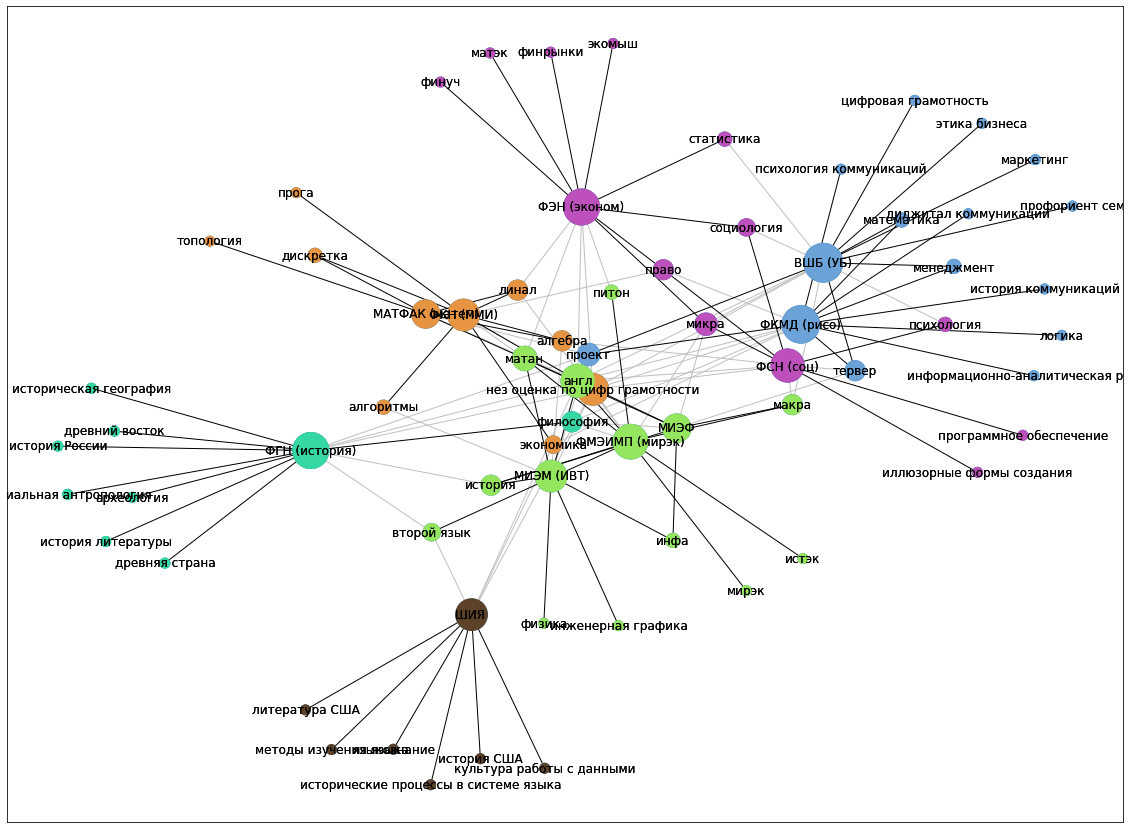

In [70]:

    # Find the communities
communities = sorted(nxcom.greedy_modularity_communities(G1), key=len, reverse=True)
    # Count the communities
print(f"Your dataset has {len(communities)} communities.")
nodes(G1, communities)
edges(G1)
node_color = [colors(G1.nodes[v]['community']) for v in G1.nodes]
    # Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in G1.edges if G1.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G1.edges if G1.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]
pos = nx.spring_layout(G1)

d = dict(G.degree)

plt.rcParams.update({'figure.figsize': (20, 15)})

nx.draw_networkx(
    G1,
    pos=pos,
    node_size=[v * 100 for v in d.values()],
    edgelist=external,
    edge_color="silver")


    # Draw nodes and internal edges
nx.draw_networkx(
    G1,
    pos=pos,
    node_size=[v * 100 for v in d.values()],
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)


plt.show()

### 3.3 Results 

###### It is important to mention that this results are within the model, for now there is no statistical evidence that this reflects the situation in a correct way:

1) Two of the faculties are independent from others (this means that their community consists of them and subjects, no other faculties are in there). They are both completely humanitarian. Indeed, it is very common for humanitarian faculties to study very rare and unique subjects and patterns they usually follow are unsimilar

2) The orange community is the faculty of Computer Science and faculty of Maths. Again, the result is intuitively clear, since both of them are based on mathematics

3) The largest community has been found, consisting of 3 areas (World Economy, Institute of Electronics and Mathematics (MIEM) and ICEF). In general, it is logical why World Economy and ICEF were there, since these are very similar programs that simultaneously study economics and its relationship with the outside world. However, a really surprising and slightly shocking observation turned out to be the connection of these directions with MIEM and the simultaneous absence of a FES in it. If I were to make connections manually, based on my experience of studying at the HSE, I would form a community of FES, World Economy and ICEF and MIEM would join to faculty of Maths and FCS, or I would single it out in a separate category. I am almost sure that if we had considered a set of courses for all the years of study, the result would have been different. Nevertheless, based on the subjects of the 1st course, there is such a connection.

4) Faculty of social sciences (FSS) is in one community with FES. This is not contradictory, in my view, since economists do study many humanitarian courses to become generally educated. Moreover, economists and sociologists both deal with researches and statistics and often share the same background before starting education

5) The last community is formed by faculty of Design and Business School. What they have in common is that most amount of work is done by implementing practical projects. At the same time, this result is not obvious for me since I believe that managers are clother to economists and designers should be in their own category

### 3.4 Get back to the Louvain method

Now we can compare the results with the previous method. The major advantage of the Louvain method is that MIEM is now in one community with faculty of Maths and FCS. This makes more sense, however, I still do not understand why FES is not with World Ecoomy and ICEF. FSS is now with Business School, instead of FES. Both previous and this connections with FSS are fine for me, and there are no significant differences anymore. That is why, I can say that Louvain worked better in this example. However, I will not use it for further analysis. This is because it it very complicated to justify it with the picture. In case of Modularity, I see how all the idead were developed from the graph. From it I see why FSS can be in the same community as Business School. As for technical faculties, this comes from our prior beliefs about differences or similarities of faculties. That is why the justification of the Louvain algorithm comes not from the algorithm itself, hence, I will use the results of the Modularity case in the further analysis

# 4 Original results

### 4.1 What was before
I want to show an image of the network that was constructed in Gephi when the first version of project was made (the nice thing about Gephi is that we can make network visually more beuatiful by applying different algorithms, I used Yifan Hu one). After that I want to compare the results of both final results the convinience of tools we used

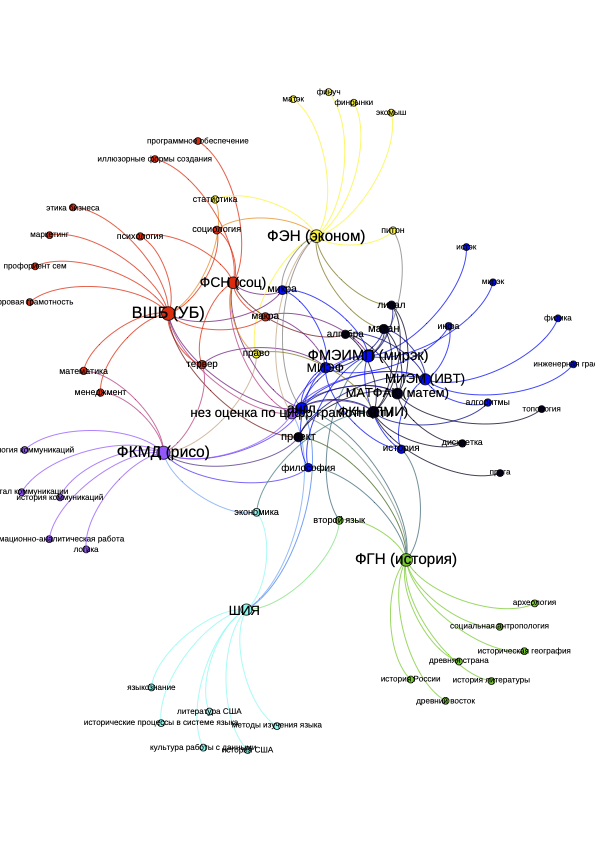

In [71]:
from IPython.display import Image
Image('image.png')

### 4.2 Let's describe the new network:

1) It has 4 independent faculties. All of them, except economics, are humanitarian

2) The communities with Maths, FCS, ICEF, World Economy and MIEM are identical to ones that were in the previous graph

3) FSS is now with Business School

### 4.3 Similarities and differences

###### 4.3.1 Similarities:

1) Both networks identified the largest community and the Maths \& Computer Science one in the same way

2) Both identified faculties that cannot be associated with another ones (we will call them outliers)

3) Nodes that are located in the center are approximately the same (by center I mean a place, where there is the biggest number of faculties and subjects)

###### 4.3.2 Differencies:

1) The number of outliers is different. The Gephi built-in Modularity method found 4, the Python Modularity method identidied 2

2) FSS is now with Business School (we have already exaplined why it is reasonable and valid)

### 4.4 Python VS Gephi

###### 4.4.1 Why Gephi?

1) Specialized tool with more tecniques (speaking about network analysis)

2) More convenient framework

3) More options to visually observe the network

###### 4.4.2 Why Python?

1) Universal (we can do not only network analysis, but data processing, data analysis, applying ML tools etc.)

2) Reliable and respected (many people have Python, know how to use it and trust it)

3) Availability (I believe, in many companies Gephi is not available, while Python should be)

# 5 Plans for the future

1) Make graph weighted. By this we will make sure, that mathematics at the faculty of Mathematics is more advanced and important, than mathematics at the faculty of foreign languages and so on. As a result, we kill two birds with one stone, as two major factors are taken into account

2) Add more data (all subjects, more educational programms of faculties, more faculties and more universities). The secret of a successful model is all about data. If our dataset will represent the entire situation on the educational market, we will be able to find unexpected and informative relationships within different faculties of different universities

3) Try more algorithms. Here we speak about another algorithms of community detection. This is not about clustering, since in clustering we put objects together based of their charasterics, and here we see merely an interaction with other objects